# Importar paquetes necesarios

In [1]:
!pip install mabwiser
# -*- coding: utf-8 -*-

import pandas as pd
from sklearn.preprocessing import StandardScaler

from mabwiser.mab import MAB, LearningPolicy, NeighborhoodPolicy

import random
from mabwiser.simulator import Simulator

from time import time

     |████████████████████████████████| 53 kB 1.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# Problema con contexto:

Una plataforma de comercio virtual cuenta con 5 ads y quiere determinar cuál de estos generará mayor revenue para un usuario en específico. Para esto, se cuenta con información histórica de revenues obtenidos por otros usuarios en distintos ads junto con la información de la edad, la razón de clicks y si cada usuario es subscriptor o no.

In [2]:
# Arms
ads = [1, 2, 3, 4, 5]

# Historical data of ad decisions with corresponding revenues and context information
train_df = pd.DataFrame({'ad': [1, 1, 1, 2, 4, 5, 3, 3, 2, 1, 4, 5, 3, 2, 5],
                         'revenues': [10, 17, 22, 9, 4, 20, 7, 8, 20, 9, 50, 5, 7, 12, 10],
                         'age': [22, 27, 39, 48, 21, 20, 19, 37, 52, 26, 18, 42, 55, 57, 38],
                         'click_rate': [0.2, 0.6, 0.99, 0.68, 0.15, 0.23, 0.75, 0.17,
                                        0.33, 0.65, 0.56, 0.22, 0.19, 0.11, 0.83],
                         'subscriber': [1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]}
                        )

# Test data to for new prediction
test_df = pd.DataFrame({'age': [37, 52], 'click_rate': [0.5, 0.6], 'subscriber': [0, 1]})
test_df_revenue = pd.Series([7, 13])

# Scale the training and test data
scaler = StandardScaler()
train = scaler.fit_transform(train_df[['age', 'click_rate', 'subscriber']].values.astype('float64'))
test = scaler.transform(test_df.values.astype('float64'))

In [3]:
########################################################
# KNearest Neighborhood Policy with UCB1 Learning Policy
########################################################

# KNearest context policy with k equals to 5 and ucb1 learning with alpha of 1.25
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

# Learn from previous ads shown and revenues generated
knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

# Predict the next best ad to show
prediction = knearest.predict(test)

# Expectation of each ad based on learning from past ad revenues
expectations = knearest.predict_expectations(test)

# Results
print("KNearest: ", prediction, " ", expectations)
assert(prediction == [5, 1])

# Online update of model
knearest.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)

# Updating of the model with new arm
knearest.add_arm(6)

KNearest:  [5, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]


#Actividad 1:
Suponga que a este mismo usuario, se le presenta el nuevo ad, $6$, obteniendo un revenue de $40$. Usando el método _partial_fit_ simule este caso e imprima las nuevas expectations. Comente los resultados obtenidos

In [4]:
# Test data to for new prediction
test_df = pd.DataFrame({'age': [37, 52], 'click_rate': [0.5, 0.6], 'subscriber': [0, 1]})
test_df_revenue = pd.Series([6, 40])

# Scale the training and test data
scaler = StandardScaler()
train = scaler.fit_transform(train_df[['age', 'click_rate', 'subscriber']].values.astype('float64'))
test = scaler.transform(test_df.values.astype('float64'))

In [5]:
########################################################
# KNearest Neighborhood Policy with UCB1 Learning Policy
########################################################

# KNearest context policy with k equals to 5 and ucb1 learning with alpha of 1.25
knearest = MAB(arms=ads,
               learning_policy=LearningPolicy.UCB1(alpha=1.25),
               neighborhood_policy=NeighborhoodPolicy.KNearest(k=5))

# Learn from previous ads shown and revenues generated
knearest.fit(decisions=train_df['ad'], rewards=train_df['revenues'], contexts=train)

# Predict the next best ad to show
prediction = knearest.predict(test)

# Expectation of each ad based on learning from past ad revenues
expectations = knearest.predict_expectations(test)

# Results
print("KNearest: ", prediction, " ", expectations)
assert(prediction == [5, 1])

# Online update of model
knearest.partial_fit(decisions=prediction, rewards=test_df_revenue, contexts=test)

# Updating of the model with new arm
knearest.add_arm(6)

KNearest:  [5, 1]   [{1: 14.5857953014744, 2: 11.242653222492628, 3: 0, 4: 0, 5: 16.5857953014744}, {1: 24.242653222492628, 2: 17.5857953014744, 3: 10.242653222492628, 4: 0, 5: 7.242653222492627}]


Se obtuvieron los mismos resultados que en el caso anterior.

#Problema sin contexto:

El sitio ahora quiere elegir entre dos posibles opciones de diseño para su homepage. Para esto tiene datos históricos del revenue aportado por cada diseño, pero no cuenta con ningún dato acerca de los usuarios.

In [6]:
# Arms
options = [1, 2]

# Historical data of layouts decisions and corresponding rewards
layouts = [1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1]
revenues = [10, 17, 22, 9, 4, 0, 7, 8, 20, 9, 50, 5, 7, 12, 10]

In [7]:
###################################
# Epsilon Greedy Learning Policy
###################################

# Epsilon Greedy learning policy with random exploration set to 15%
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=123456)

# Learn from previous layouts decisions and revenues generated
greedy.fit(decisions=layouts, rewards=revenues)

# Predict the next best layouts decision
prediction = greedy.predict()

# Expected revenues of each layouts learnt from historical data based on epsilon greedy policy
expectations = greedy.predict_expectations()

# Results
print("Epsilon Greedy: ", prediction, " ", expectations)
# assert(prediction == 1)

# Additional historical data becomes available which allows _online learning
additional_layouts = [1, 2, 1, 2]
additional_revenues = [0, 12, 7, 19]

# Online updating of the model
greedy.partial_fit(additional_layouts, additional_revenues)

Epsilon Greedy:  1   {1: 10.875, 2: 14.714285714285714}


# Actividad 2:

Suponga que en un experimento online, se le muestra a un usuario ambos diseños y el revenue obtenido es exactamente el estimado por el agente. ¿Qué esperaría que pase al actualizar el modelo? Simule este caso en $5$ iteraciones, imprimiendo las expectations. Comente los resultados observados.

In [10]:
greedy = MAB(arms=options,
             learning_policy=LearningPolicy.EpsilonGreedy(epsilon=0.15),
             seed=123456)

# Learn from previous layouts decisions and revenues generated
greedy.fit(decisions=layouts, rewards=revenues)

# Predict the next best layouts decision
prediction = greedy.predict()

# Expected revenues of each layouts learnt from historical data based on epsilon greedy policy
expectations = greedy.predict_expectations()

# Results
print("Epsilon Greedy: ", prediction, " ", expectations)
# assert(prediction == 1)

# Additional historical data becomes available which allows _online learning
additional_layouts = [1, 2, 1, 2,1]
additional_revenues = [0, 12, 7, 19,25]

# Online updating of the model
greedy.partial_fit(additional_layouts, additional_revenues)

Epsilon Greedy:  1   {1: 10.875, 2: 14.714285714285714}


Nuevamente obtenemos los mismos resultados para 5 iteraciones.

#Simulación:

Vamos a simular un multi-armed bandits para un dataset aleatorio con $1000$ entradas de datos y comparar los rendimientos de cada learning-policy:

In [11]:
size = 1000

decisions = [random.randint(0, 2) for _ in range(size)]
rewards = [random.randint(0, 1000) for _ in range(size)]
contexts = [[random.random() for _ in range(50)] for _ in range(size)]

In [12]:
####################################
# Different Bandits for Simulation
####################################

print('Starting simulation 1\n')


def binarize(decision, reward):

    return reward >= 500

n_jobs=2
contextual_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize),
                                            NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15),
                                         NeighborhoodPolicy.Radius(10), n_jobs=n_jobs)),
                   ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), NeighborhoodPolicy.Radius(10), n_jobs=n_jobs))]

context_free_mabs = [('Random', MAB([0, 1], LearningPolicy.Random(), n_jobs=n_jobs)),
                     ('UCB1', MAB([0, 1], LearningPolicy.UCB1(1), n_jobs=n_jobs)),
                     ('ThompsonSampling', MAB([0, 1], LearningPolicy.ThompsonSampling(binarize), n_jobs=n_jobs)),
                     ('EpsilonGreedy', MAB([0, 1], LearningPolicy.EpsilonGreedy(epsilon=.15), n_jobs=n_jobs)),
                     ('Softmax', MAB([0, 1], LearningPolicy.Softmax(), n_jobs=n_jobs))]

Starting simulation 1



2021-11-08 11:39:50,096 INFO Simulation Parameters
2021-11-08 11:39:50,098 INFO 	 bandits: [('Random', <mabwiser.mab.MAB object at 0x7fdf31e7d9d0>), ('UCB1', <mabwiser.mab.MAB object at 0x7fdf31e7d490>), ('ThompsonSampling', <mabwiser.mab.MAB object at 0x7fdf31e7db10>), ('EpsilonGreedy', <mabwiser.mab.MAB object at 0x7fdf31e7dbd0>), ('Softmax', <mabwiser.mab.MAB object at 0x7fdf31e7dc90>)]
2021-11-08 11:39:50,099 INFO 	 scaler: None
2021-11-08 11:39:50,103 INFO 	 test_size: 0.5
2021-11-08 11:39:50,105 INFO 	 is_ordered: False
2021-11-08 11:39:50,106 INFO 	 batch_size: 0
2021-11-08 11:39:50,107 INFO 	 evaluator: <function default_evaluator at 0x7fdf38475ef0>
2021-11-08 11:39:50,109 INFO 	 seed: 123456
2021-11-08 11:39:50,112 INFO 	 is_quick: False
2021-11-08 11:39:50,113 INFO 	 log_file: None
2021-11-08 11:39:50,115 INFO 	 format: %(asctime)s %(levelname)s %(message)s
2021-11-08 11:39:50,116 INFO 

2021-11-08 11:39:50,119 INFO Total Stats
2021-11-08 11:39:50,125 INFO {0: {'count': 317, 

Complete 0.00947642723719279 minutes


Random
Worst Case Scenario: {0: {'count': 269, 'sum': 36211, 'min': 1, 'max': 1000, 'mean': 134.61338289962825, 'std': 272.21547194570496}, 1: {'count': 231, 'sum': 45783, 'min': 1, 'max': 991, 'mean': 198.19480519480518, 'std': 304.15656023368484}}
Average Case Scenario: {0: {'count': 269, 'sum': 132433.22222222225, 'min': 5.0, 'max': 1000.0, 'mean': 492.31681123502693, 'std': 150.52137425976383}, 1: {'count': 231, 'sum': 118783.11976047907, 'min': 1.0, 'max': 991.0, 'mean': 514.2126396557535, 'std': 173.97949328066707}}
Best Case Scenario: {0: {'count': 269, 'sum': 235011, 'min': 5, 'max': 1000, 'mean': 873.6468401486989, 'std': 255.03048472794964}, 1: {'count': 231, 'sum': 189913, 'min': 1, 'max': 1000, 'mean': 822.1341991341991, 'std': 289.08611667873856}}



UCB1
Worst Case Scenario: {0: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std': nan}, 1: {'count': 500, 'sum': 86477, 'min': 1, 'max': 991, 'mean': 172.954, 'std': 285.

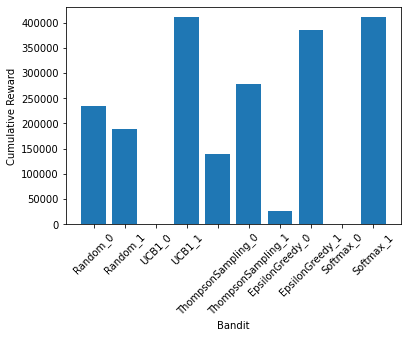

In [13]:
####################################
# Context-Free Simulation
####################################
start = time()
sim = Simulator(context_free_mabs, decisions, rewards, contexts=None,
                scaler=None, test_size=0.5, is_ordered=False, batch_size=0, seed=123456)
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name])

    print('\n\n')

sim.plot('max', True) 
# Vamos a plotear el best case scenario para todos los bandidos utilizados. El parámetro True indica que en el plot se va a plotear por separado cada "brazo"

#Actividad 3: Simulación "on-line" con contexto.

Basándose en el código anterior, vamos a repetir este experimento para los bandidos con contexto definidos anteriormente. Recuerde que los datos de contextos deben ser escalados, por lo que debe cambiar el parámetro scaler.

Esta simulación, a diferencia de la anterior, simulará un agente que se va actualizando de manera "on-line", en donde en cada iteración, los agentes reciben $100$ datos y en base a estos, actualizan sus políticas. Para hacer esto, solo debe modificar el parámetro de batch-size. Comente sus resultados

Streaming output truncated to the last 5000 lines.
2021-11-08 11:43:29,142 INFO Random batch 54 confusion matrix: [[3 0]
 [1 0]]
2021-11-08 11:43:29,142 INFO Random batch 54 confusion matrix: [[3 0]
 [1 0]]
2021-11-08 11:43:29,145 INFO Random {0: {'count': 4, 'sum': 1182, 'min': 1, 'max': 688, 'mean': 295.5, 'std': 262.2560771459834}, 1: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std': nan}}
2021-11-08 11:43:29,145 INFO Random {0: {'count': 4, 'sum': 1182, 'min': 1, 'max': 688, 'mean': 295.5, 'std': 262.2560771459834}, 1: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std': nan}}
2021-11-08 11:43:29,148 INFO Random {0: {'count': 4, 'sum': 1663.111111111111, 'min': 125.0, 'max': 688.0, 'mean': 415.77777777777777, 'std': 203.30978916513186}, 1: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std': nan}}
2021-11-08 11:43:29,148 INFO Random {0: {'count': 4, 'sum': 1663.111111111111, 'min': 125.0, 'max': 688.0, 'mean': 415.77777777777777, '

Complete 1.1236613750457765 minutes


Random
Worst Case Scenario: {0: {'count': 238, 'sum': 30286, 'min': 1, 'max': 989, 'mean': 127.25210084033614, 'std': 254.6234893310432}, 1: {'count': 262, 'sum': 40895, 'min': 1, 'max': 989, 'mean': 156.08778625954199, 'std': 280.17164164512127}}
Average Case Scenario: {0: {'count': 238, 'sum': 113037.11111111112, 'min': 5.0, 'max': 989.0, 'mean': 474.94584500466857, 'std': 153.0600335483086}, 1: {'count': 262, 'sum': 130508.9401197605, 'min': 1.0, 'max': 989.0, 'mean': 498.12572564794084, 'std': 176.1631513321764}}
Best Case Scenario: {0: {'count': 238, 'sum': 201254, 'min': 5, 'max': 995, 'mean': 845.6050420168067, 'std': 285.4082353663156}, 1: {'count': 262, 'sum': 217827, 'min': 1, 'max': 1000, 'mean': 831.4007633587786, 'std': 301.6573742672288}}



UCB1
Worst Case Scenario: {0: {'count': 0, 'sum': nan, 'min': nan, 'max': nan, 'mean': nan, 'std': nan}, 1: {'count': 500, 'sum': 86477, 'min': 1, 'max': 991, 'mean': 172.954, 'std': 285.883738404

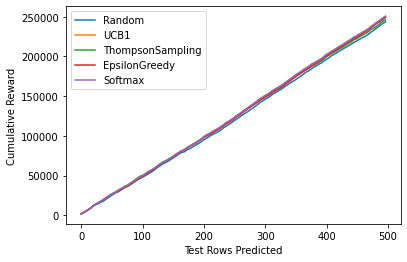

In [14]:
start = time()
sim = Simulator(context_free_mabs, decisions, rewards, contexts=None,
                scaler=None, test_size=0.5, is_ordered=False, batch_size=4, seed=123456)
sim.run()
end = time()

runtime = (end - start) / 60
print('Complete', str(runtime) + ' minutes')
print('\n')

for mab_name, mab in sim.bandits:
    print(mab_name)

    # Como esta simulación es online, se debe específicar que imprima el valor 'total'
    print('Worst Case Scenario:', sim.bandit_to_arm_to_stats_min[mab_name]['total'])
    print('Average Case Scenario:', sim.bandit_to_arm_to_stats_avg[mab_name]['total'])
    print('Best Case Scenario:', sim.bandit_to_arm_to_stats_max[mab_name]['total'])

    print('\n\n')

sim.plot('avg', False)
# Como buscamos ahora maximizar el revenue, no separaremos los resultados por brazo, sino que se graficará de manera conjunta el revenue promedio obtenido por cada agente.

Vemos en la grafica como los datos se van actualizando y la recompensa crece de manera lineal.